In [1]:
import pandas as pd
import numpy as np
import scipy
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.integrate import trapz
from functools import reduce

In [2]:
class CustomDataLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        """
        Loads soccer player position data from a CSV file and returns it as a numpy array.

        Returns:
            A numpy array with shape (num_frames, num_players, 2), where:
                - num_frames: The number of frames in the data file
                - num_players: The number of players (always 11 for soccer)
                - 2: The x and y coordinates of each player at each frame

        Raises:
            FileNotFoundError: If the file path provided does not exist

        """
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(self.file_path)
        
        # Filter rows where Period equals 1
        df = df[df["Period"] == 1]

        # Extract the player position columns and reshape into a 3D array
        player_cols = [f'Player{i}-x' for i in range(1, 15)]  # column names for player x positions
        num_frames = len(df)  # number of frames in the data
        num_players = 14  # total number of players, although only 11 can be on the field at once
        player_positions = np.zeros((num_frames, num_players, 2))  # 3D array to store player positions

        # Loop through the frames and player columns
        for i, frame_group in enumerate(df.groupby('Frame')):
            frame_num, frame_data = frame_group
            for j, player_col in enumerate(player_cols):
                # Get the x and y values for the current player and frame
                y_col = player_col.replace('-x', '-y')
                x_val = frame_data[player_col].values[0]
                y_val = frame_data[y_col].values[0]

                # If both x and y values are valid (i.e., not NaN), store them in the 3D array
                if not np.isnan(x_val) and not np.isnan(y_val):
                    player_positions[i, j, :] = [x_val, y_val]
                    
        # Normalize tracking data to have zero mean in each frame                 
        for row in range(player_positions.shape[0]):
            mean_pos = sum(player_positions[row]) / 11       # Calculate mean position of all active players in this frame
            for coor in player_positions[row]:               # Subtract mean position from each player's position in this frame
                if (coor != 0).any(axis=0):
                    coor -= mean_pos

        return player_positions

In [3]:
class SoccerFormation:
    def __init__(self, data, num_roles, max_iterations=10, convergence_threshold=0.001):
        self.data = data
        self.num_roles = num_roles
        self.max_iterations = max_iterations
        self.convergence_threshold = convergence_threshold
        self.template_formation = None
        self.role_assignments = None
        self.role_probabilities = None
        
    def _initialize_template_formation(self, num_roles):
        # randomly assign players to roles for the template formation
        player_indices = np.arange(num_roles)
        np.random.shuffle(player_indices)
        role_indices = np.array_split(player_indices, self.num_roles)
        self.template_formation = np.zeros((self.num_roles, num_roles))
        for i, indices in enumerate(role_indices):
            self.template_formation[i, indices] = 1
            
    def _initialize_template(self, X):
        '''KMeans will likely result in a more representative and cohesive template formation 
        than the random assignment used in the previous implementation.
        
        Loop through the players and cluster their positions separately for a total of 11 clusters
        
        This results in a template of shape (11, 1, 2), with one cluster center per player.'''
        # Initialize an empty array for the template formation
        template = np.zeros((self.num_roles, 1, X.shape[2]))
        cluster_covs = np.zeros((self.num_roles, 1, X.shape[2], X.shape[2]))

        # Loop through each player and cluster their positions separately
        for player in range(self.num_roles):
            kmeans = KMeans(n_clusters=1)
            nonzero_mask = np.any(X[:, player, :] != [0.0, 0.0], axis=1)  # We only want to select the data points for players != [0.0, 0.0]
            nonzero_X = X[:, player, :][nonzero_mask]  
            kmeans.fit(nonzero_X) # This will select all rows from the first dimension, 
                                  # the positions for the current player from the second dimension, 
                                  # and both x and y coordinates from the third dimension.
            template[player] = kmeans.cluster_centers_
            
            # Compute the covariance matrix of the cluster
            labels = kmeans.predict(nonzero_X)
            cluster_covs[player] = np.cov(nonzero_X[labels == 0].T)

        return template, cluster_covs

    def plot_clusters(self, template, cluster_covs):
        """
        Plots the soccer player positions along with their corresponding clusters as 2D Gaussians.

        Args:
            template: A numpy array of shape (11, 1, 2) containing the cluster centers for each player
            cluster_covs: A numpy array of shape (11, 1, 2, 2) containing the covariance matrices for each player's cluster

        """
        # Set up the figure
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_aspect('equal')

        # Plot the player positions as dots
        for i in range(template.shape[0]):
            x, y = template[i][0]
            ax.plot(x, y, 'o', markersize=10, alpha=0.5, label=f'Player {i+1}')

            # Get the cluster covariance matrix and mean
            cov = cluster_covs[i][0]
            mean = template[i][0]

            # Get the eigenvalues and eigenvectors of the covariance matrix
            eigenvalues, eigenvectors = np.linalg.eigh(cov)

            # Plot the Gaussian as an ellipse
            ellipse = Ellipse(xy=mean, width=2*np.sqrt(eigenvalues[0]), height=2*np.sqrt(eigenvalues[1]), 
                              angle=np.degrees(np.arctan2(*eigenvectors[:, 0][::-1])), edgecolor=f'C{i}', lw=2, fill=False, alpha=0.5)
            ax.add_artist(ellipse)

            # Plot the player number at the centroid of the ellipse
            ax.annotate(str(i+1), xy=mean, ha='center', va='center', fontsize=12)

        # Set the axis limits and add a legend
        ax.set_xlim([-0.5, 0.5])
        ax.set_ylim([-0.5, 0.5])

        plt.show()

In [4]:
prob = CustomDataLoader(file_path = "Sample_Game_1_RawTrackingData_Home_Team.csv")
player_positions = prob.load_data()

Initial Formation


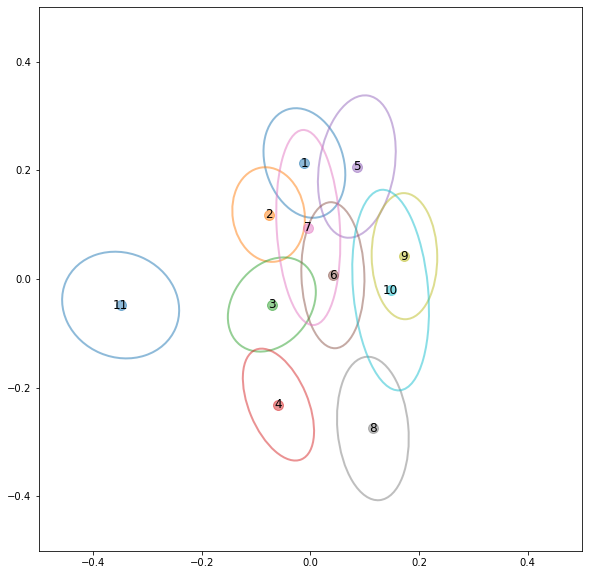

Iterating through the data set...
Iteration: 1 Delta: 0.062043841073839735


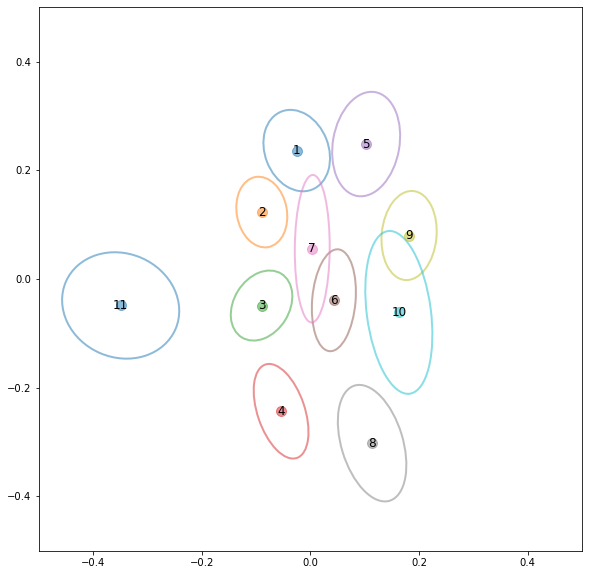

Iterating through the data set...
Iteration: 2 Delta: 0.00904210469147728


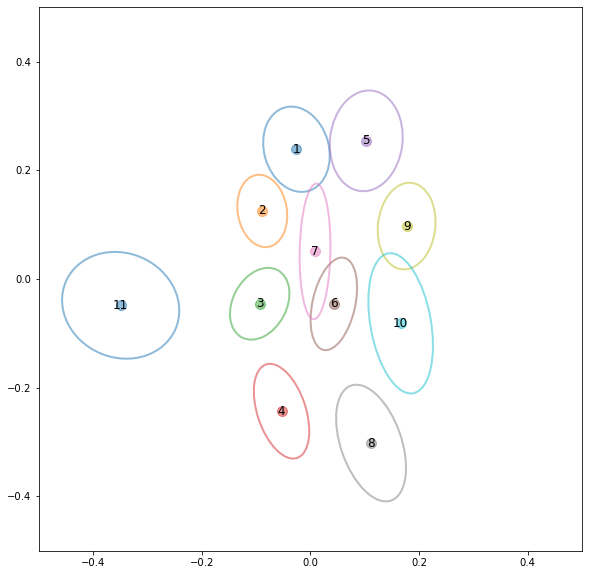

Iterating through the data set...
Iteration: 3 Delta: 0.003688151640302222


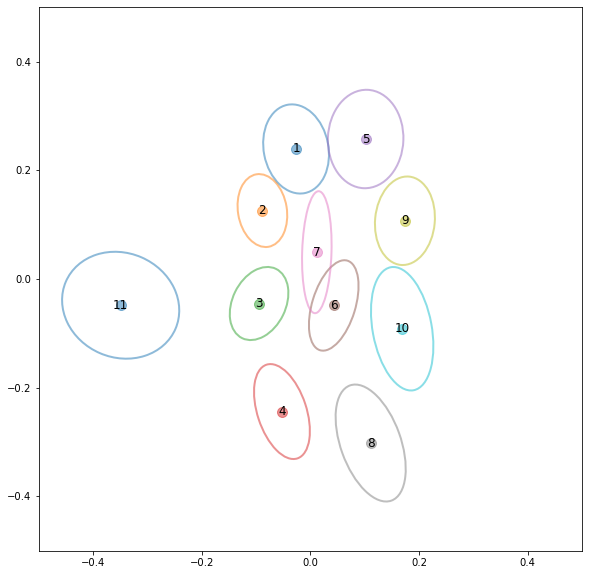

Iterating through the data set...
Iteration: 4 Delta: 0.0013111083112748237


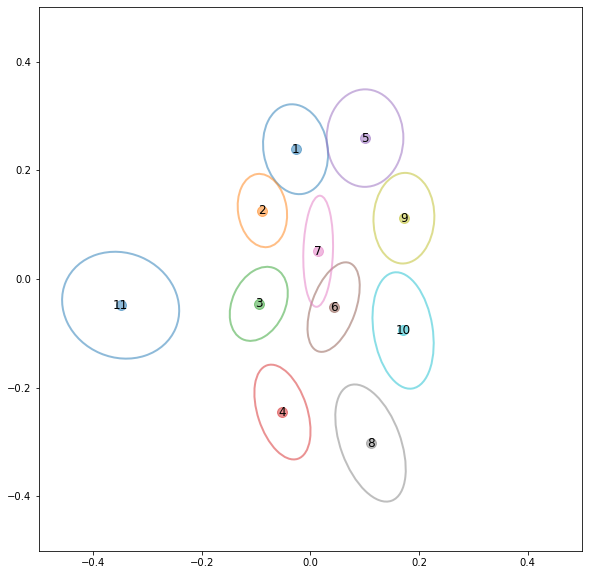

Iterating through the data set...
Iteration: 5 Delta: 0.000900408145616067


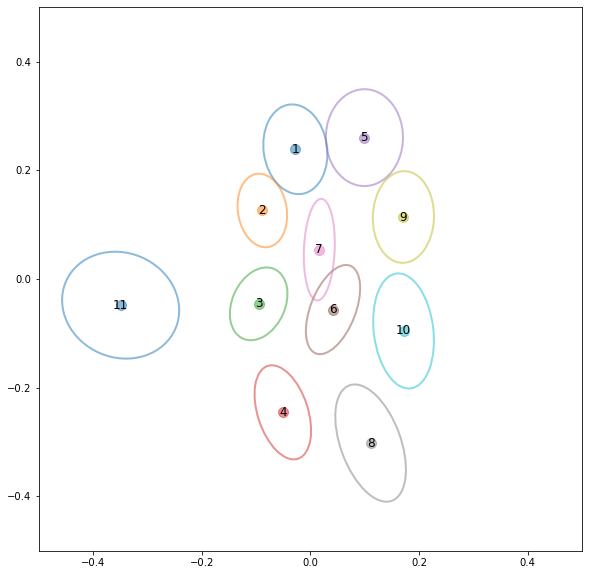

Iterating through the data set...
Iteration: 6 Delta: 0.002046912674473331


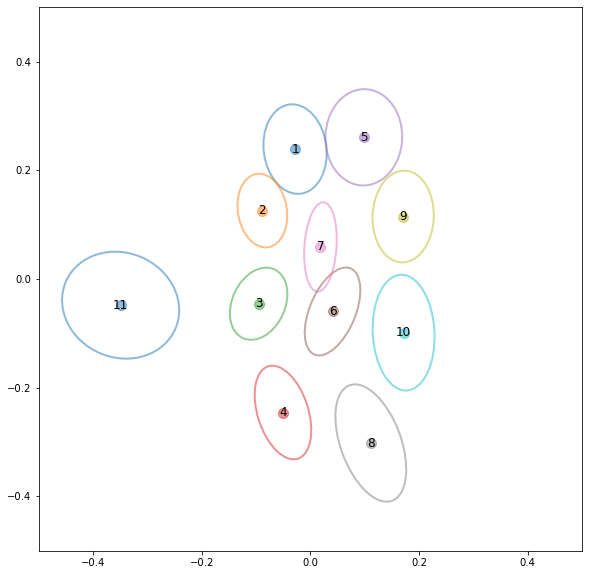

Iterating through the data set...
Iteration: 7 Delta: 0.0003804139721919909


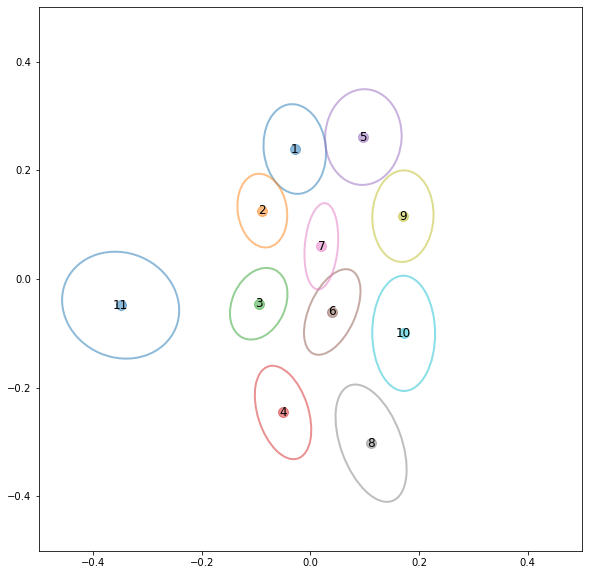

Iterating through the data set...
Iteration: 8 Delta: 0.0003322461404653943


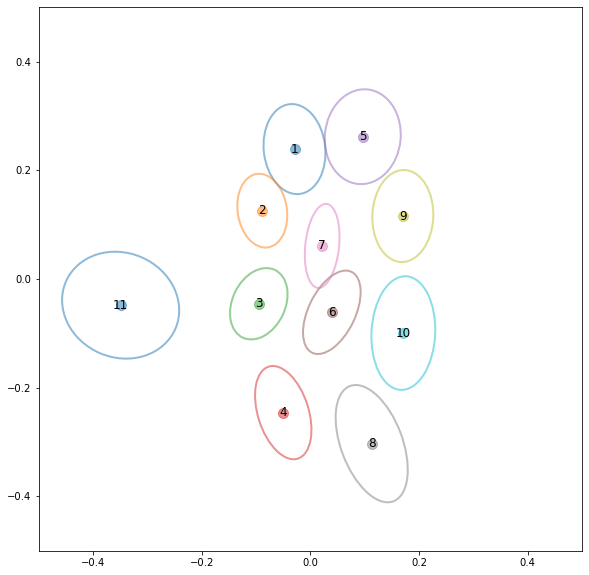

Iterating through the data set...
Iteration: 9 Delta: 0.0002675862605130911


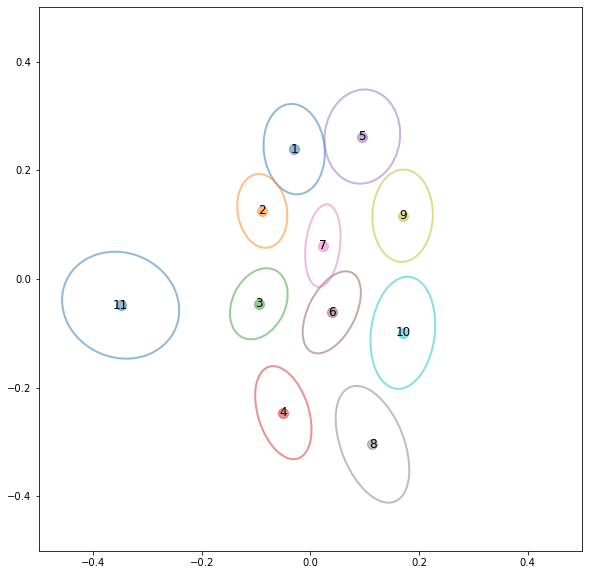

Iterating through the data set...
Iteration: 10 Delta: 0.00029732368101204596


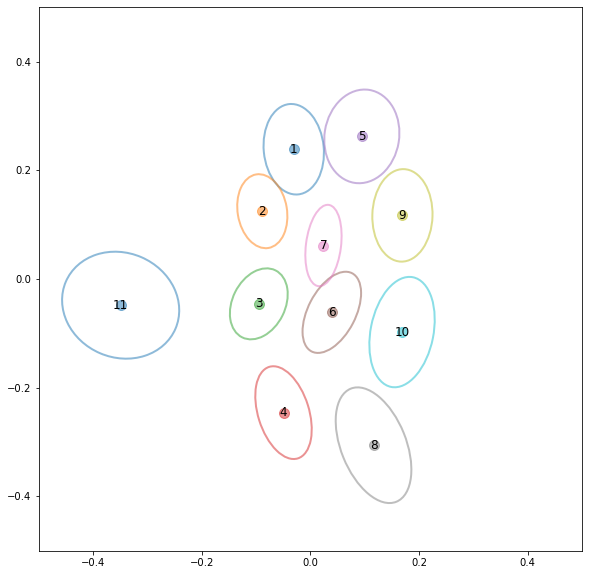

Iterating through the data set...
Iteration: 11 Delta: 0.00010251265582225536


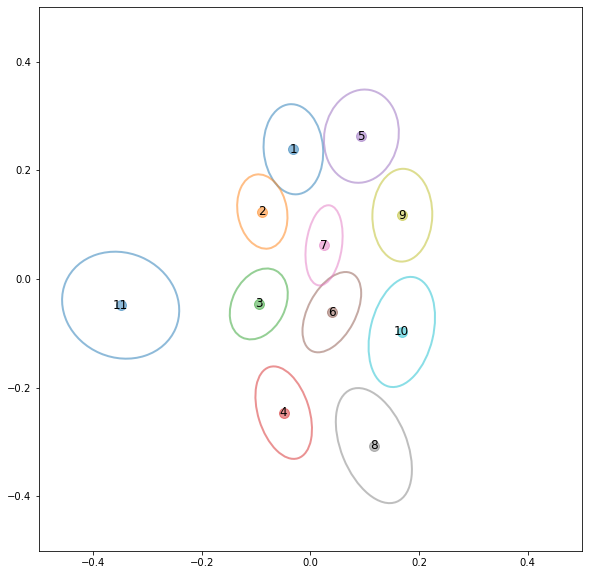

Iterating through the data set...
Iteration: 12 Delta: 7.826409975961858e-05


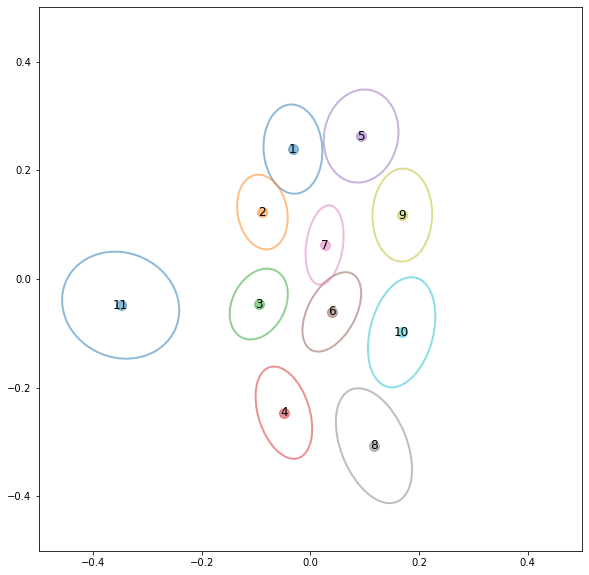

In [40]:
X = copy.deepcopy(player_positions)
num_roles = 11
num_players = 14
num_iterations = 10
iteration = 0
# set a threshold value for the change in probability density functions
entropy_method_threshold = 1e-4
difference_method_threshold = 1e-3 

# Arbitrarily initialize the template formation
formation = SoccerFormation(player_positions, num_roles)

# Compute means and covariances for each role before iterating through the data
'''to be done before iterating through the data because it involves 
computing the mean and covariance for each role based on the initial 
role distribution, which is set outside the loop. These means and 
covariances will be used to compute the log probabilities in the cost 
matrix for each (x,y) position and each role label, which will be used 
to assign role labels to the tracking data at each frame in the loop.'''
template, cluster_covs = formation._initialize_template(player_positions)

# Initial compute of the probability density functions of each role.
'''Create a multivariate normal distribution for each role with mean given by 
the cluster center and covariance given by the covariance matrix of the cluster 
for the corresponding player'''
Pn_prev = []
for n in range(num_roles):
    pdf = scipy.stats.multivariate_normal(mean=template[n, 0], cov=cluster_covs[n, 0])
    Pn_prev.append(pdf)
    
# Plot the initial role distributions
print('Initial Formation')
formation.plot_clusters(template, cluster_covs)


# Iterate EM algorithm until convergence
while True:    
    iteration+=1
    # Define a dictionary to store the [x,y] coor pairs assigned to each of the 11 roles by the Hungarian algorithm
    data_for_new_pdfs = {'Role 1': [],
                         'Role 2': [],
                         'Role 3': [],
                         'Role 4': [],
                         'Role 5': [],
                         'Role 6': [],
                         'Role 7': [],
                         'Role 8': [],
                         'Role 9': [],
                         'Role 10': [],
                         'Role 11': [],
                        }    

    # Iterate through each frame of tracking data
    print('Iterating through the data set...')
    for row in range(X.shape[0]):
        # Initialize the count matrix
        role_labels = np.zeros((11, 11))
        
        # Extract only the non-zero x,y coordinate pairs
        nonzero_mask = np.any(X[row] != [0.0, 0.0], axis=1)  # We only want to select the data points for players != [0.0, 0.0]
        nonzero_X = X[row][nonzero_mask] 

        # Create a cost matrix based of the log probability of each (x,y) position being assigned a particular role label
        cost_matrix = np.zeros((11, 11))
        for role in range(num_roles): 
            for player in range(11):
                cost_matrix[role,player] = np.log(Pn_prev[role].pdf(nonzero_X[player])) 

        # Use the Hungarian algorithm to compute the optimal assignment
        '''The scipy implementation of the algorithm is based on the Munkres algorithm, 
        which is a specific version of the Hungarian algorithm.'''
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix, maximize = True) # Expectation Maximization

        # Assign role labels to the tracking data and update the count matrix for each frame
        for i, j in zip(row_ind, col_ind):
            role_labels[i, j] += 1

        '''Create a dictionary for all 11 roles. Based on the output of the role_lables matrix at each row, 
        append to the respective k, the coordinate pair of the player responsible for that role assignment. 
        I can recompute the mean/covariance later for each of the 11 roles by accessing the [x,y] pairs at each key'''
        for row in range(role_labels.shape[0]):
            data_idx = np.where(role_labels[row] == 1)[0][0]
            data_for_new_pdfs[f'Role {row+1}'].append(list(nonzero_X[data_idx]))

    '''Once role labels have been assigned to all
    frames of the tracking data, we recompute the probability
    density functions of each role.

    New mean vectors and covariance matrices are computed using the player 
    coordinate pairs assigned to each of the 11 roles by the Hungarian algorithm.

    New multivariate normal distributions for each role are next computed
    using the updated mean vectors and covariance matrices.'''

    # Compute new mean vectors and covariance matrices for each role
    new_templates = np.zeros((num_roles, 1, 2))
    new_cluster_covs = np.zeros((num_roles, 1, 2, 2))
    for role, matched_coords in data_for_new_pdfs.items():
        # Convert matched_coords to a NumPy array
        matched_coords = np.array(matched_coords)
        # Compute the centroid of the matched coordinates
        new_mean = matched_coords.mean(axis=0)
        # Compute the covariance matrix of the matched coordinates
        new_cov = np.cov(matched_coords, rowvar=False)
        # Create new multivariate normal distributions for each role
        new_templates[int(role[-2:]) - 1, 0, :] = new_mean
        new_cluster_covs[int(role[-2:]) - 1, 0, :, :] = new_cov

    # Recompute probability density functions for each role
    Pn_new = []
    for n in range(num_roles):
        pdf = scipy.stats.multivariate_normal(mean=new_templates[n, 0, :], cov=new_cluster_covs[n, 0, :, :])
        Pn_new.append(pdf)
        
#     '''PDF Difference Convergence Criteria'''
#     # compute change in probability density functions
#     delta = []
#     for n in range(num_roles):
#         nonzero_mask = X[:, n, :].any(axis=1)
#         nonzero_X = X[:, n, :][nonzero_mask] 
#         delta.append(abs(Pn_new[n].logpdf(nonzero_X) - Pn_prev[n].logpdf(nonzero_X)))
        
#     # find the set of indices that have valid delta values for all roles
#     valid_indices = reduce(set.intersection, [set(np.where(np.isfinite(d))[0]) for d in delta])

#     # calculate average delta using valid indices
#     delta_avg = np.mean([d[i] for i in valid_indices for d in delta])

#     # Plot the updated role distributions
#     print(f'Iteration: {iteration} Delta: {delta_avg}')
#     formation.plot_clusters(new_templates, new_cluster_covs)    
    
#     # check for convergence
#     if delta_avg < difference_method_threshold:
#         break
        
    '''Entropy Difference Convergence Criteria'''
    # compute change in probability density function entropy
    entropies = []
    for n in range(num_roles):
        nonzero_mask = X[:, n, :].any(axis=1)
        nonzero_X = X[:, n, :][nonzero_mask] 
        entropy = scipy.stats.entropy(Pn_new[n].pdf(nonzero_X), Pn_prev[n].pdf(nonzero_X))
        '''The scipy.stats.entropy function takes two probability distributions 
        as input, and computes the Kullback-Leibler divergence from the second to 
        the first distribution. If the two distributions are identical, the result is 0. 
        The function returns the entropy value in nats (natural logarithmic units) by default'''
        entropies.append(entropy)
        
    # calculate average entropy
    entropy_avg = np.mean(entropies)
    
    # Plot the updated role distributions
    print(f'Iteration: {iteration} Delta: {entropy_avg}')
    formation.plot_clusters(new_templates, new_cluster_covs)  
    
    # check for convergence
    if entropy_avg < entropy_method_threshold:
        break

    # update previous probability density functions
    Pn_prev = Pn_new.copy()